# Scraping and displaying international information

## Gather the QS ranking data

In [1]:
import pandas as pd

In [2]:
# Here using code from stackoverflow user 10987432/paul-m, adapted to scrape all the component data from QS 2022
# How do we extract different years? Not sure yet...

In [3]:
def get_entries():
    import requests

    url = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/en/3740566_indicators.txt?1637817445?v=1637823042256"

    headers = {
        "user-agent": "Mozilla/5.0",
        "x-requested-with": "XMLHttpRequest"
    }

    response = requests.get(url, headers=headers)
    response.raise_for_status()

    def make_pretty(entry):
        from bs4 import BeautifulSoup as Soup
        return {
            "name": Soup(entry["uni"], "html.parser").select_one(".uni-link").get_text(strip=True),
            "region": entry["region"],
            "location": entry["location"],
            "city": entry["city"],
            "rank": entry["overall_rank"],
            "overallscore": Soup(entry["overall"], "html.parser").select_one(".td-wrap-in").get_text(strip=True),
            "internationalfacultyratio": Soup(entry["ind_18"], "html.parser").select_one(".td-wrap-in").get_text(strip=True),
            "academicreputation": Soup(entry["ind_76"], "html.parser").select_one(".td-wrap-in").get_text(strip=True),
            "citations": Soup(entry["ind_73"], "html.parser").select_one(".td-wrap-in").get_text(strip=True),
            "facultystudentratio": Soup(entry["ind_36"], "html.parser").select_one(".td-wrap-in").get_text(strip=True),
            "employerrep": Soup(entry["ind_77"], "html.parser").select_one(".td-wrap-in").get_text(strip=True),
            "internationalstudentratio": Soup(entry["ind_14"], "html.parser").select_one(".td-wrap-in").get_text(strip=True)
        }

    yield from map(make_pretty, response.json()["data"])

#def main():
    
#    from itertools import islice

    #for entry in islice(get_entries(), 5):
        #print(entry)
    
#    return 0


#if __name__ == "__main__":
#    import sys
#    sys.exit(main())

In [4]:
# This runs the above scrape and puts the data into a pandas dataframe:
qs2022 = pd.DataFrame(get_entries())

In [5]:
# There are 1300 institutions in the 2022 rankings:
len(qs2022)

1300

In [6]:
# The data (first and last few rows) looks like this - overall scores plus individual components measures included, as well as
# institute name, region (=continent), location (=country) and city
qs2022

,name,region,location,city,rank,overallscore,internationalfacultyratio,academicreputation,citations,facultystudentratio,employerrep,internationalstudentratio
0,Massachusetts Institute of Technology (MIT),North America,United States,Cambridge,1,100,100,100,100,100,100,91.4
1,University of Oxford,Europe,United Kingdom,Oxford,2,99.5,99.5,100,96,100,100,98.5
2,Stanford University,North America,United States,Stanford,3,98.7,99.8,100,99.9,100,100,67
3,University of Cambridge,Europe,United Kingdom,Cambridge,4,98.7,100,100,92.1,100,100,97.7
4,Harvard University,North America,United States,Cambridge,5,98,84.2,100,100,99.1,100,70.1
...,...,...,...,...,...,...,...,...,...,...,...,...
1295,Université de Tunis,Africa,Tunisia,Tunis,1296,-,-,5,1.5,19.1,1.4,-
1296,Université de Tunis El Manar,Africa,Tunisia,Tunis,1297,-,1.2,5.5,3.5,14.5,1.6,1.9
1297,Yarmouk University,Asia,Jordan,Irbid,1298,-,1.2,9.3,2.2,1.9,10.2,11
1298,Yildiz Technical University,Asia,Turkey,Istanbul,1299,-,1.1,5.6,5.4,6.1,10.5,8.9


In [7]:
# I want to clean the data a little bit
# (i) keep the name of institution only up to the first comma or bracket, to avoid issues later
# (ii) make a new column "place", which is "city, country". This is for the geographic data - for most institutions I can find
# geographical, but maybe not for those written in Arabic etc; "city" is not enough, as e.g., both U Cambridge and MIT are in 
# "Cambridge", so need country to distinguish

In [8]:
# (i) only keep names up to the first comma or bracket
qs2022['name'] = qs2022.name.apply(lambda x: x.split(',')[0])
qs2022['name'] = qs2022.name.apply(lambda x: x.split('(')[0])
# (ii) make new "place" column
qs2022['place'] = qs2022.city+', '+qs2022.location

In [9]:
qs2022

,name,region,location,city,rank,overallscore,internationalfacultyratio,academicreputation,citations,facultystudentratio,employerrep,internationalstudentratio,place
0,Massachusetts Institute of Technology,North America,United States,Cambridge,1,100,100,100,100,100,100,91.4,"Cambridge, United States"
1,University of Oxford,Europe,United Kingdom,Oxford,2,99.5,99.5,100,96,100,100,98.5,"Oxford, United Kingdom"
2,Stanford University,North America,United States,Stanford,3,98.7,99.8,100,99.9,100,100,67,"Stanford, United States"
3,University of Cambridge,Europe,United Kingdom,Cambridge,4,98.7,100,100,92.1,100,100,97.7,"Cambridge, United Kingdom"
4,Harvard University,North America,United States,Cambridge,5,98,84.2,100,100,99.1,100,70.1,"Cambridge, United States"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,Université de Tunis,Africa,Tunisia,Tunis,1296,-,-,5,1.5,19.1,1.4,-,"Tunis, Tunisia"
1296,Université de Tunis El Manar,Africa,Tunisia,Tunis,1297,-,1.2,5.5,3.5,14.5,1.6,1.9,"Tunis, Tunisia"
1297,Yarmouk University,Asia,Jordan,Irbid,1298,-,1.2,9.3,2.2,1.9,10.2,11,"Irbid, Jordan"
1298,Yildiz Technical University,Asia,Turkey,Istanbul,1299,-,1.1,5.6,5.4,6.1,10.5,8.9,"Istanbul, Turkey"


In [10]:
# Now we add the location data in latitude, longitude form, using Nominatim.
# This first tries to find the location from the "name" of institution, but if this fails (rare, but happens), it 
# uses the "place"

In [11]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="StackOverFlow", timeout=3)

In [12]:
# This takes a long time to look up all 1300 locations so don't run it every time!

#locations = []
#for i in range(len(qs2022)):
#    location_from_nominatim = geolocator.geocode(qs2022['name'][i], addressdetails=True, language='en')
#    if location_from_nominatim!=None:
#        locations.append(location_from_nominatim)
#    else:
#        locations.append(geolocator.geocode(qs2022['place'][i], addressdetails=True, language='en'))
        
# qs2022["location_info"] = locations 


In [13]:
# I think I had to fix a single entry manually...

# qs2022.at[294,'location_info'] = geolocator.geocode('xian jiaotong university', addressdetails=True, language='en')

In [14]:
# For ease later we'll make separate columns for latitude and longitude

# qs2022['latitude'] = qs2022.location_info.apply(lambda x: x.raw['lat'])
# qs2022['longitude'] = qs2022.location_info.apply(lambda x: x.raw['lon'])

In [15]:
# Because it takes a long time, here I just save the data to a csv file so I can read it in again

#qs2022.to_csv('qs2022_data.csv')

In [16]:
qs2022data = pd.read_csv('qs2022_data.csv')

In [17]:
# So here is the QS data with latitude and longitude data for each institution

qs2022data

,Unnamed: 0,name,region,location,city,rank,overallscore,internationalfacultyratio,academicreputation,citations,facultystudentratio,employerrep,internationalstudentratio,place,location_info,latitude,longitude
0,0,Massachusetts Institute of Technology,North America,United States,Cambridge,1,100,100,100.0,100.0,100,100.0,91.4,"Cambridge, United States","Massachusetts Institute of Technology, Dr. Pau...",42.358253,-71.096627
1,1,University of Oxford,Europe,United Kingdom,Oxford,2,99.5,99.5,100.0,96.0,100,100.0,98.5,"Oxford, United Kingdom","Sherardian Library of Plant Taxonomy, South Pa...",51.759037,-1.252430
2,2,Stanford University,North America,United States,Stanford,3,98.7,99.8,100.0,99.9,100,100.0,67,"Stanford, United States","Stanford University, 408, Panama Mall, Stanfor...",37.431314,-122.169365
3,3,University of Cambridge,Europe,United Kingdom,Cambridge,4,98.7,100,100.0,92.1,100,100.0,97.7,"Cambridge, United Kingdom",Museum of Classical Archaeology and Faculty of...,52.200623,0.110474
4,4,Harvard University,North America,United States,Cambridge,5,98,84.2,100.0,100.0,99.1,100.0,70.1,"Cambridge, United States","Harvard University, Western Avenue, Barry's Co...",42.367909,-71.126782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,1295,Université de Tunis,Africa,Tunisia,Tunis,1296,-,-,5.0,1.5,19.1,1.4,-,"Tunis, Tunisia","Université de Monastir, شارع الطاهر الحداد, ال...",35.763306,10.829230
1296,1296,Université de Tunis El Manar,Africa,Tunisia,Tunis,1297,-,1.2,5.5,3.5,14.5,1.6,1.9,"Tunis, Tunisia","جامعة تونس المنار, نهج البشير سالم بلخيرية, كو...",36.829187,10.146311
1297,1297,Yarmouk University,Asia,Jordan,Irbid,1298,-,1.2,9.3,2.2,1.9,10.2,11,"Irbid, Jordan","Yarmouk University, King Abdullah II Eben Al H...",32.537208,35.855490
1298,1298,Yildiz Technical University,Asia,Turkey,Istanbul,1299,-,1.1,5.6,5.4,6.1,10.5,8.9,"Istanbul, Turkey","Yıldız Technical University, Barbaros Bulvarı,...",41.052244,29.010528


In [18]:
# now we have latitudes and longitudes for every university in the QS2022 rankings, along with all the QS ranking data

## Plotting the data on a map

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [20]:
# Basemap has a bunch of map projections and other basic data preloaded. 

In [21]:
# In case we need it I downloaded a list of countries with latitude and longitude data, but I don't think it's necessary
# I don't know what "importance" means either!
countries = "countries.csv"
country_data = pd.read_csv(countries)

In [22]:
country_data

,Country,Importance,Altitude,Latitude,Longitude
0,Afghanistan,0.747027,0.0,33.768006,66.238514
1,Albania,0.727912,0.0,41.000028,19.999962
2,Algeria,0.758319,0.0,28.000027,2.999983
3,Andorra,0.779500,0.0,42.540717,1.573203
4,Angola,0.831118,0.0,-11.877577,17.569124
...,...,...,...,...,...
179,Vietnam,0.751195,0.0,13.290403,108.426511
180,West Bank and Gaza,0.607844,0.0,31.433166,34.377929
181,Western Sahara,0.606775,0.0,24.179732,-13.766785
182,Zambia,0.794923,0.0,-14.518624,27.559916


In [23]:
fig = plt.figure(figsize=(12,9))

<Figure size 1200x900 with 0 Axes>

In [24]:
# We can use Basemap to draw a basic map of the world, choosing a particular projection, e.g. choose one of

#m = Basemap(projection = 'mill', llcrnrlat = -90, urcrnrlat = 90, llcrnrlon = -180, urcrnrlon = 180, resolution = 'c')
#m = Basemap(projection = 'moll', lon_0 = 0, resolution = 'c')
#m = Basemap(projection='gall',llcrnrlat=-60,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180,resolution='c')
m = Basemap(projection='mill',llcrnrlat=-60,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180,resolution='c')

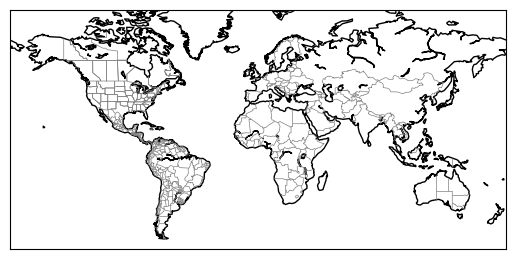

In [25]:
# Here is just coastlines and country/state borders

m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')
plt.show()

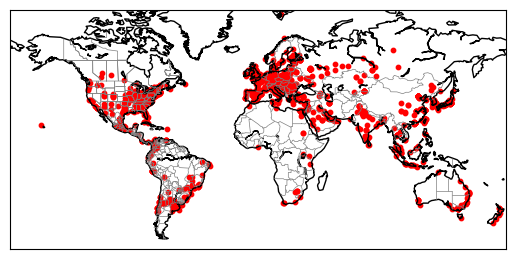

In [26]:
# We can add to this the location of all 1300 QS institutions:

m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')

# creating variable for latitude and longitude to list
lat = [float(x) for x in qs2022data['latitude'].tolist()]
lon = [float(x) for x in qs2022data['longitude'].tolist()]

# plotting the QS locations
m.scatter(lon, lat, latlon = True, s = 10, c = 'red', marker = 'o', alpha = 1)

plt.show()

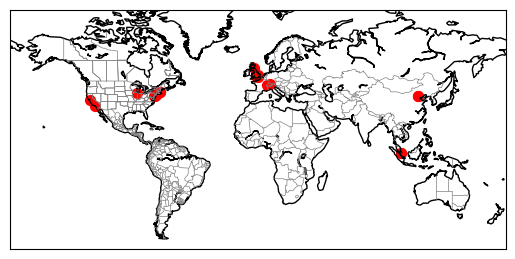

In [28]:
# Or just plot the locations of the QS top 20 institutions:

m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')

qsdata_selection = pd.DataFrame.copy(qs2022data.sort_values(by='rank')[:20])

# creating variable for latitude and longitude to list
lat = [float(x) for x in qsdata_selection['latitude'].tolist()]
lon = [float(x) for x in qsdata_selection['longitude'].tolist()]

# plotting the QS locations
m.scatter(lon, lat, latlon = True, s = 50, c = 'red', marker = 'o', alpha = 1)

plt.show()

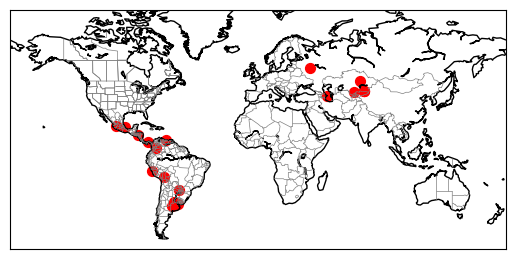

In [30]:
# Or top 20 by citations - but be careful because by default values are sorted
# in descending order (which is correct for rankings), so this is actually the
# *bottom* 20 by citations:

m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')

qsdata_selection = pd.DataFrame.copy(qs2022data.sort_values(by='citations')[:20])

# creating variable for latitude and longitude to list
lat = [float(x) for x in qsdata_selection['latitude'].tolist()]
lon = [float(x) for x in qsdata_selection['longitude'].tolist()]

# plotting the QS locations
m.scatter(lon, lat, latlon = True, s = 50, c = 'red', marker = 'o', alpha = 1)

plt.show()

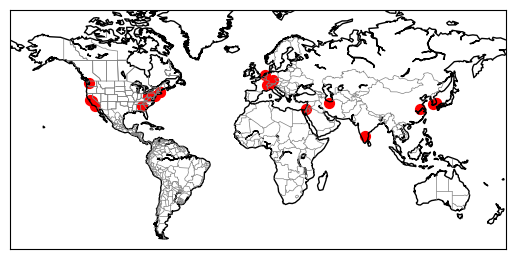

In [31]:
# Remember to add asecnding=False to reverse the order and get the top 20 when
# looking at citations (or indeed anything ordered by score rather than ranking):

m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')

qsdata_selection = pd.DataFrame.copy(qs2022data.sort_values(by='citations',ascending=False)[:20])

# creating variable for latitude and longitude to list
lat = [float(x) for x in qsdata_selection['latitude'].tolist()]
lon = [float(x) for x in qsdata_selection['longitude'].tolist()]

# plotting the QS locations
m.scatter(lon, lat, latlon = True, s = 50, c = 'red', marker = 'o', alpha = 1)

plt.show()

In [32]:
# Basemap can also draw much prettier maps, but takes much longer!:

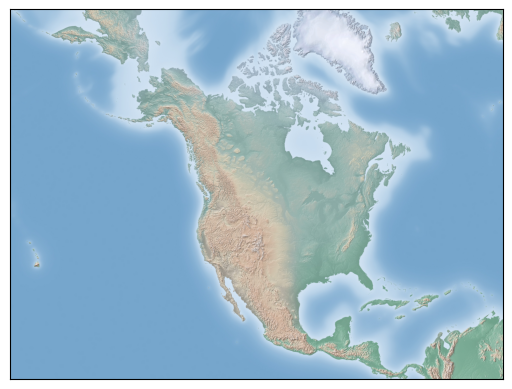

In [33]:
# setup Lambert Conformal basemap.
# set resolution=None to skip processing of boundary datasets.
m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution=None,lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
m.shadedrelief()
plt.show()

## Plotting some local (EPS) data

In [41]:
# This is a file of 2022/23 Research Mobility Fund awards in EPS - awardees, School, (main) partner, title, amount

rmf = "EPS_ISF_details.csv"
rmfdata = pd.read_csv(rmf)

In [42]:
rmfdata

,Name,School,Partner,Partner Country,Project Title,Award value
0,Rob Beadling,Mech Eng,University of Cape Town,South Africa,Addressing MSK Health Challenges – Total Shoul...,"£4,000.00"
1,Susan Bernal Lopez,Civil Eng,Paul Scherrer Institute,Switzerland,Water movement in cementitious materials – a n...,"£4,360.00"
2,Michael Brockdorff,Elec Eng,Max Planck Stuttgart,Germany,Soft Tentacles for the Deployment of Magnetic ...,"£2,995.00"
3,Pete Culmer,Mech Eng,Kenyatta University,Kenya,Engineering innovations to improve global surg...,"£1,700.00"
4,Heribert Eisele,Elec Eng,Stanford University,USA,GaN-based Transit-Time Diodes with Heavily Dop...,"£4,300.00"
5,Han Fang,Civil Eng,Chongqing University,China,Collaborative Research on Regenerative and Res...,"£2,000.00"
6,Dominic Jones,Elec Eng,ETH Zurich,"Switzerland, Italy",Neuromorphic Tactile Sensing for Surgical Grip...,"£2,300.00"
7,Sepideh Khodparast,Mech Eng,University of Groningen,Netherlands,Sustainable Antibacterial Materials: a biomime...,"£2,500.00"
8,Dicle Kortantamer,Civil Eng,Middle East Technical University,Turkey,Build back better: A multi-disciplinary worksh...,"£7,000.00"
9,Devesh Mistry,Physics,ETH Zurich,Switzerland,Establishing the Mistry and Anastasaki Polymer...,"£3,373.00"


In [43]:
# As before we can add geographical location data:

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="StackOverFlow", timeout=3)
rmfdata['location_info'] = rmfdata.Partner.apply(lambda x: geolocator.geocode(x, addressdetails=True, language='en'))
rmfdata['latitude'] = rmfdata.location_info.apply(lambda x: x.raw['lat'])
rmfdata['longitude'] = rmfdata.location_info.apply(lambda x: x.raw['lon'])

In [37]:
# And as before, I've saved this data now so I don't have to look it up again
# rmfdata.to_csv('eps_rmf_data_locations.csv')
rmfdata_locations = pd.read_csv('eps_rmf_data_locations.csv')

In [38]:
rmfdata_locations

,Unnamed: 0,Name,School,Partner,Partner Country,Project Title,Award value
0,0,Rob Beadling,Mech Eng,University of Cape Town,South Africa,Addressing MSK Health Challenges – Total Shoul...,"£4,000.00"
1,1,Susan Bernal Lopez,Civil Eng,Paul Scherrer Institute,Switzerland,Water movement in cementitious materials – a n...,"£4,360.00"
2,2,Michael Brockdorff,Elec Eng,Max Planck Stuttgart,Germany,Soft Tentacles for the Deployment of Magnetic ...,"£2,995.00"
3,3,Pete Culmer,Mech Eng,Kenyatta University,Kenya,Engineering innovations to improve global surg...,"£1,700.00"
4,4,Heribert Eisele,Elec Eng,Stanford University,USA,GaN-based Transit-Time Diodes with Heavily Dop...,"£4,300.00"
5,5,Han Fang,Civil Eng,Chongqing University,China,Collaborative Research on Regenerative and Res...,"£2,000.00"
6,6,Dominic Jones,Elec Eng,ETH Zurich,"Switzerland, Italy",Neuromorphic Tactile Sensing for Surgical Grip...,"£2,300.00"
7,7,Sepideh Khodparast,Mech Eng,University of Groningen,Netherlands,Sustainable Antibacterial Materials: a biomime...,"£2,500.00"
8,8,Dicle Kortantamer,Civil Eng,Middle East Technical University,Turkey,Build back better: A multi-disciplinary worksh...,"£7,000.00"
9,9,Devesh Mistry,Physics,ETH Zurich,Switzerland,Establishing the Mistry and Anastasaki Polymer...,"£3,373.00"


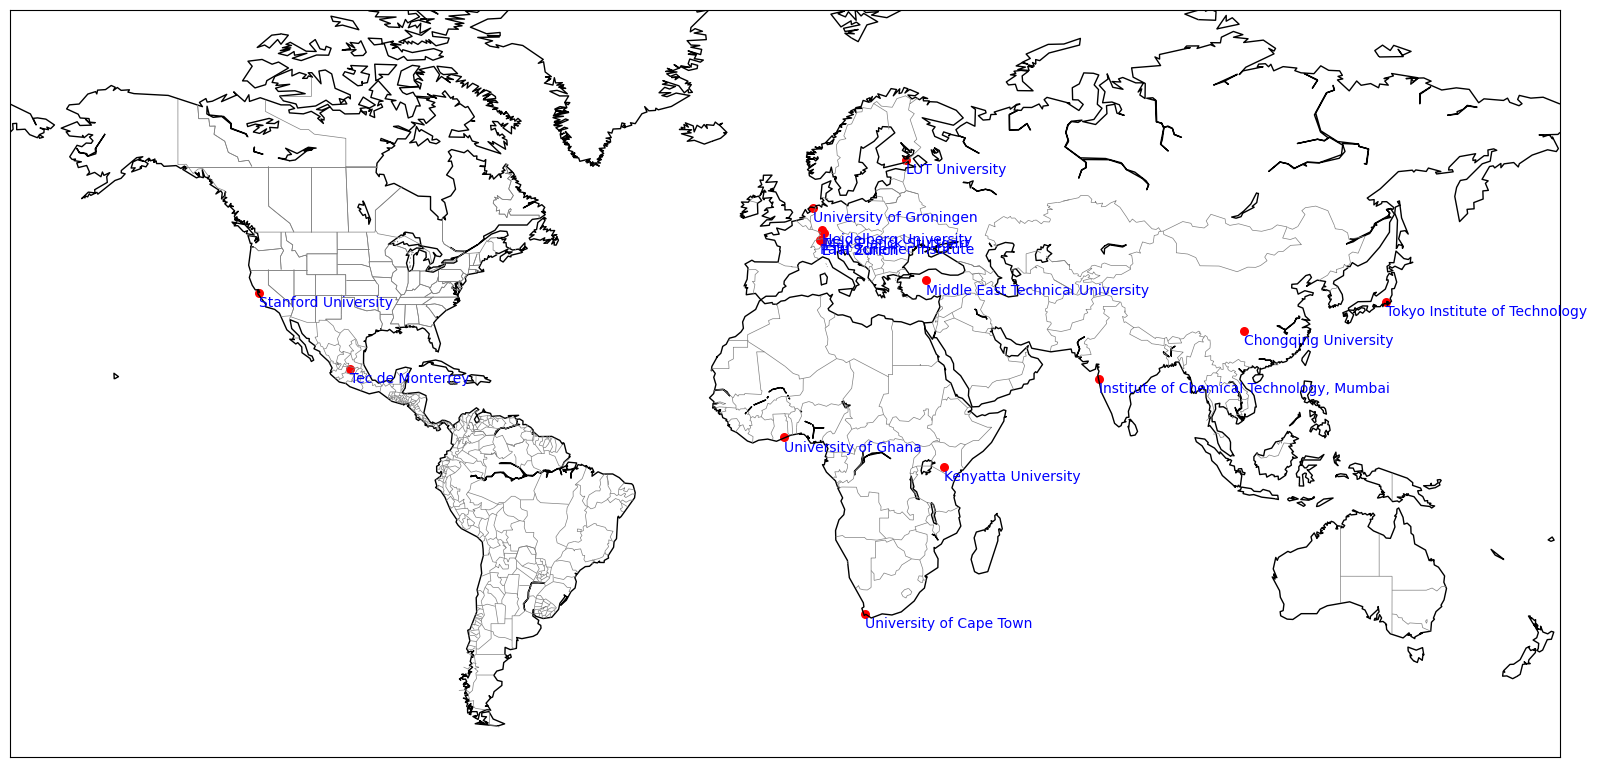

In [39]:
# Trying to plot this with labels, but looks pretty horrible!
 

fig = plt.figure(figsize=(20,16))
m = Basemap(projection='mill',llcrnrlat=-60,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')

# creating variable for latitude and longitude to list
lat = [float(x) for x in rmfdata['latitude'].tolist()]
lon = [float(x) for x in rmfdata['longitude'].tolist()]

# plotting the map
m.scatter(lon, lat, latlon = True, s = 30, c = 'red', marker = 'o', alpha = 1)

for i, txt in enumerate(rmfdata['Partner'].tolist()):
#    plt.annotate(txt, m(lon[i], lat[i]),xycoords='data',xytext=(0, -10), textcoords='offset points', color='r', arrowprops=dict(arrowstyle="fancy", color='g'))
    plt.annotate(txt, m(lon[i], lat[i]),xycoords='data',xytext=(0, -10), textcoords='offset points', color='b')

#m = Basemap(width=12000000,height=9000000,projection='lcc',resolution=None,lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
#m.shadedrelief()

plt.show()

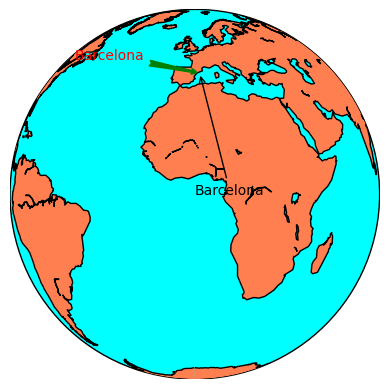

In [40]:
# Messing around with global plots and labels...

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


map = Basemap(projection='ortho', 
              lat_0=0, lon_0=0)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines()


x, y = map(2, 41)
x2, y2 = (-90, 10)

plt.annotate('Barcelona', xy=(x, y),  xycoords='data',
                xytext=(x2, y2), textcoords='offset points',
                color='r',
                arrowprops=dict(arrowstyle="fancy", color='g')
                )

x2, y2 = map(0, 0)
plt.annotate('Barcelona', xy=(x, y),  xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->")
                )
plt.show()